# SVM with Docking Scores

In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns

#### Run the helper funtions from the [Helper notebook](./Helpers.ipynb)

In [3]:
%run ./helper_functions_S6.ipynb

## Loading the results
### Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [4]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = \
open_results(path = '../data/docking_scores/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


### Ensemble Docking con ligandos DUD (2006)
- #### 2146 ligandos
    - 72 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [5]:
# Vinardo Docking Scores (dksc) DUD
X_dksc_DUD, y_dksc_DUD = \
open_results(path = '../data/docking_scores/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores DUD
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


### Ensemble Docking con ligandos DEKOIS 2.0
- #### 1240 ligandos
    - 40 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [6]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DEKOIS, y_dksc_DEKOIS = open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS_VINARDO_docking_score.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DEKOIS", X_dksc_DEKOIS.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DEKOIS, y_dkef_DEKOIS = \
open_results(
    path = '../data/docking_scores/vs_dk_CRYS_402_DEKOIS2_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DEKOIS", X_dkef_DEKOIS.shape)

Dims X_dksc_DEKOIS (1240, 402)
Dims X_dkef_DEKOIS (1240, 402)


# Merging the loaded results into a dictionary

In [7]:
# Finally we create adictionary that we will use to combine different approaches
scores_dic = {'CSAR': {'Dk_sc':   {'X': X_dksc_CSAR, 'y': y_dksc_CSAR}, 
                       'Dk_lef':  {'X': X_dkef_CSAR, 'y': y_dkef_CSAR} },
              'DUD':  {'Dk_sc':   {'X': X_dksc_DUD,  'y': y_dksc_DUD}, 
                       'Dk_lef':  {'X': X_dkef_DUD,  'y': y_dkef_DUD} },
              'DEKOIS': {'Dk_sc': {'X': X_dksc_DEKOIS,  'y': y_dksc_DEKOIS}, 
                       'Dk_lef':  {'X': X_dkef_DEKOIS,  'y': y_dkef_DEKOIS} },
             }

**Create and add the normalized ranked versions of the scoring results**:
Alternatively, we are incorporating a normalized ranked version of the results, i.e., instead of the score values, each ligand is assigned with its normalized position value inside the ranked result.

In [8]:
import copy
scores_copy = copy.deepcopy(scores_dic)

for dataset in scores_copy.keys():
    for score in scores_copy[dataset]:
        rk_name = 'Rk' + score[2:]
        scores = scores_copy[dataset][score]
        n = len(scores['y'])
        scores_dic[dataset][rk_name] = {'X': scores['X'].rank(), 'y': scores['y']}

## Pipeline

In [9]:
#TODO: Descibre the pipeline

###  Linear Support Vector Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>

The following **linear SVM** is trained using **CSAR** (*Dk_sc* and *Dk_lef*, respectively) and testing with **DUD** and **DEKOIS**.  
All conformations (402 features) are used.

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Linear SVC</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

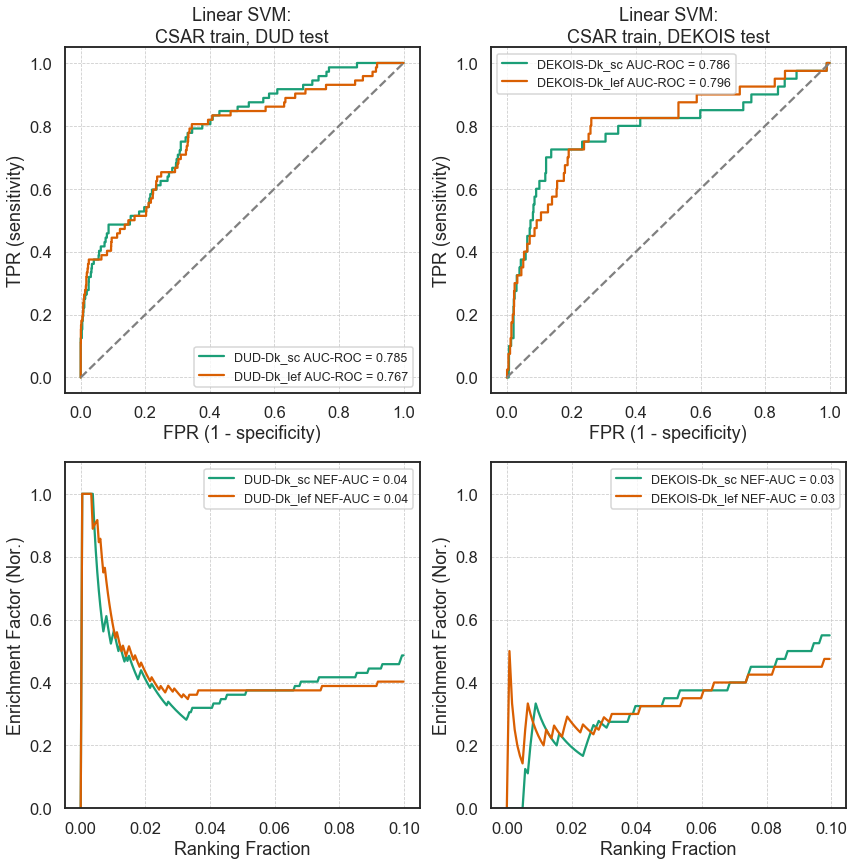

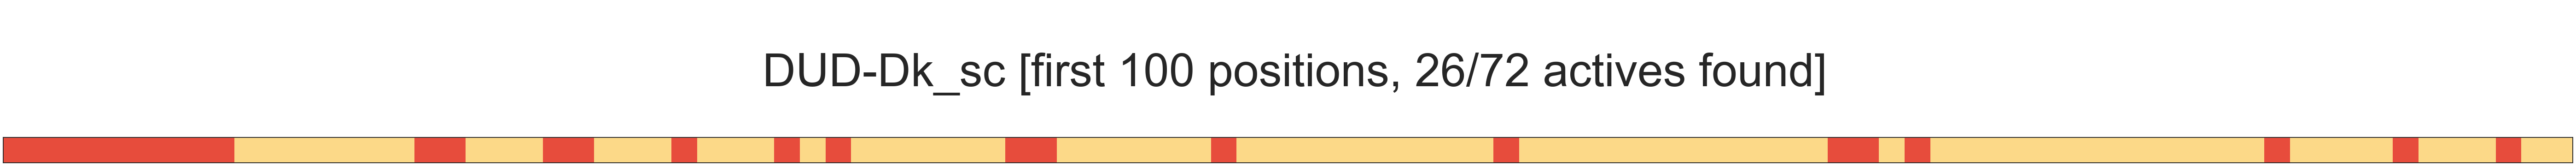

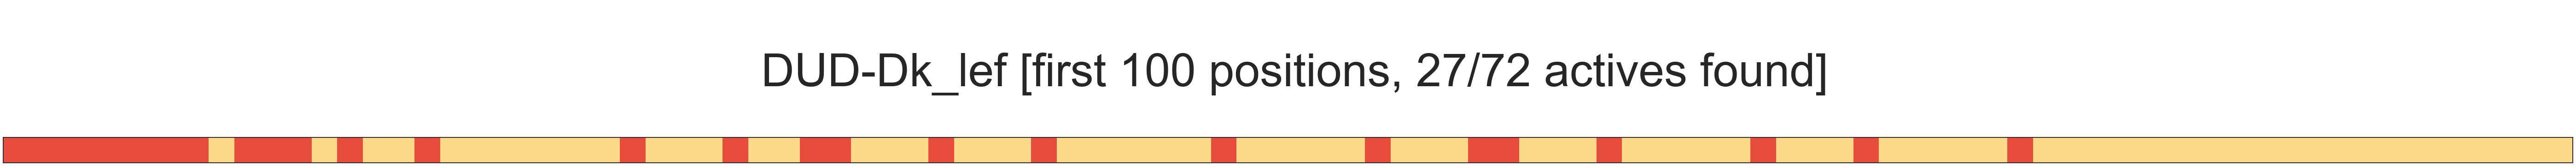

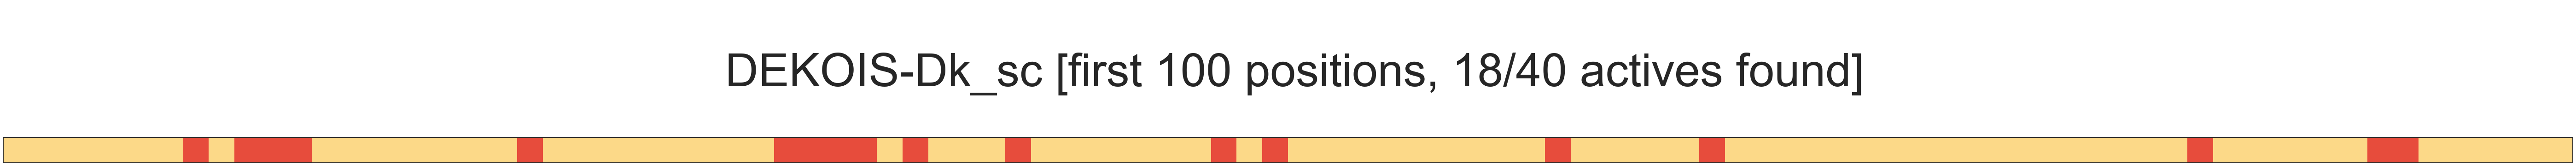

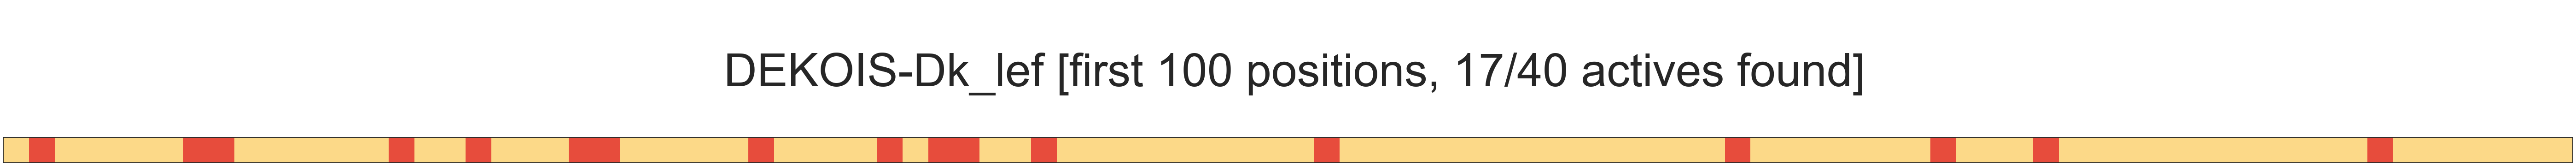

In [10]:
# Params to eval through grid search
svc_hyparams = {'C': np.geomspace(0.1, 100, 4)}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'CSAR'
# The name of the datasets which will be used for  testing
test_keys = ['DUD', 'DEKOIS']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores,
                            scores_dic = scores_dic,
                            estimator= SVC, estimator_hyparams = svc_hyparams,
                            # kwargs exclusive for SVC
                            kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)


In [11]:
# Best estimator for DkSc
svm_lineal['Dk_sc'].best_params_

{'estimator__C': 0.1}

In [12]:
## TODO: Add LinearSVC with grid search

***
###  Radial Basis Function SVC
<div style='background-color: #F9E5AB; min-height: 5px'></div>

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>RBF SVC</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

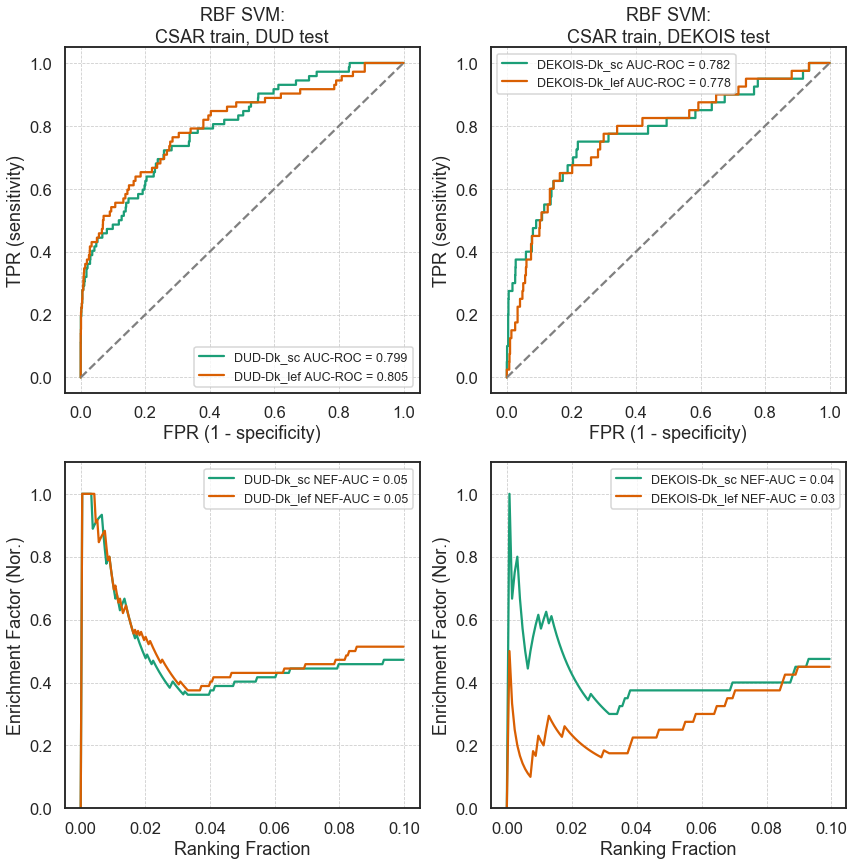

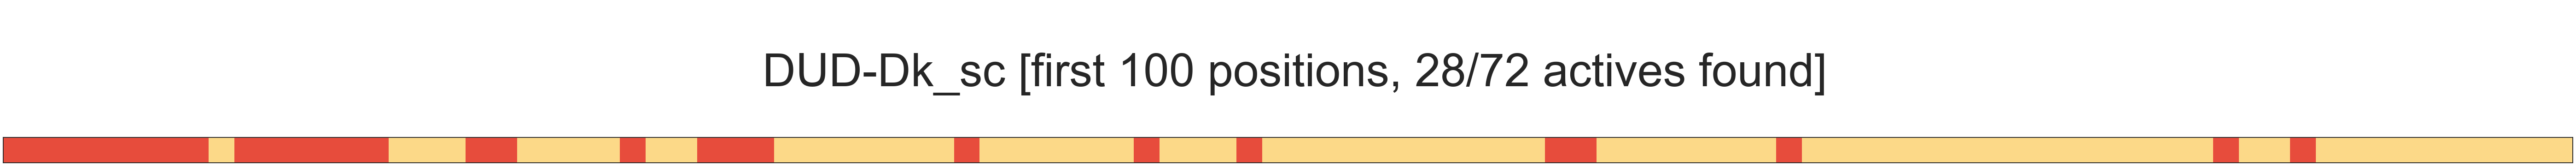

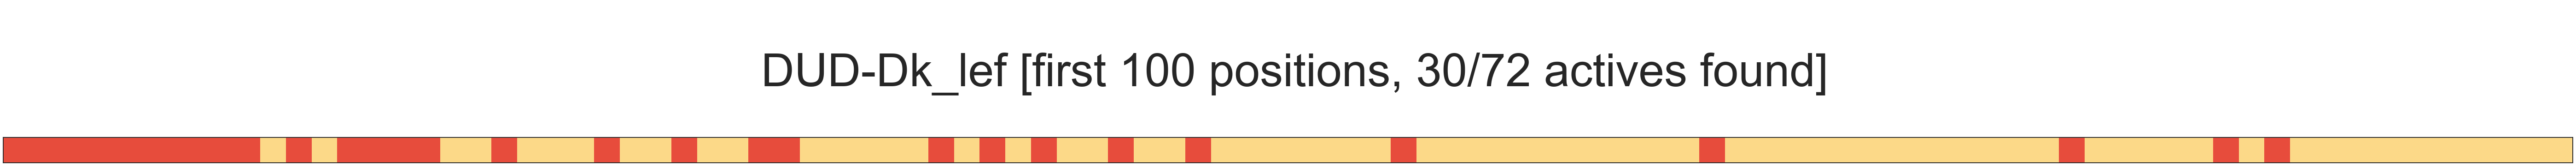

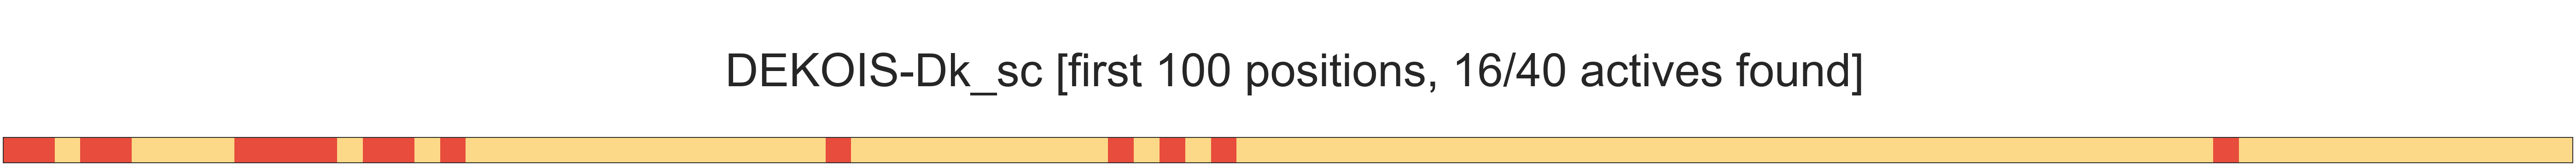

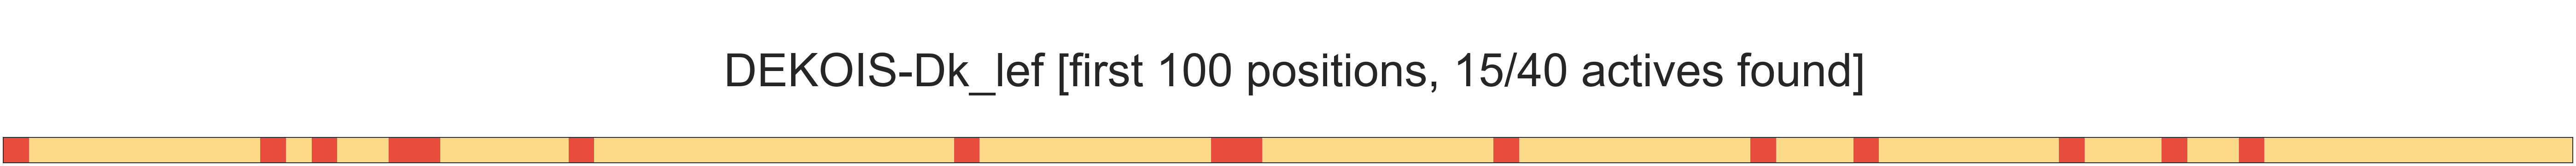

In [13]:
svc_params = {'gamma': [0.001, 0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 10, 3)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        scores_dic = scores_dic,
                        estimator= SVC, estimator_hyparams = svc_params,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = True)

In [14]:
# Best estimator for DkSc
svm_rbf['Dk_sc'].best_params_

{'estimator__C': 10.0, 'estimator__gamma': 0.001}

***
### Logistic Regression
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Logistic Regression</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [15]:
from sklearn.linear_model import LogisticRegression

Model for Dk_sc:
	Best parameters: {'estimator__C': 1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
	Train set accuracy: 0.988
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
	Train set accuracy: 0.992


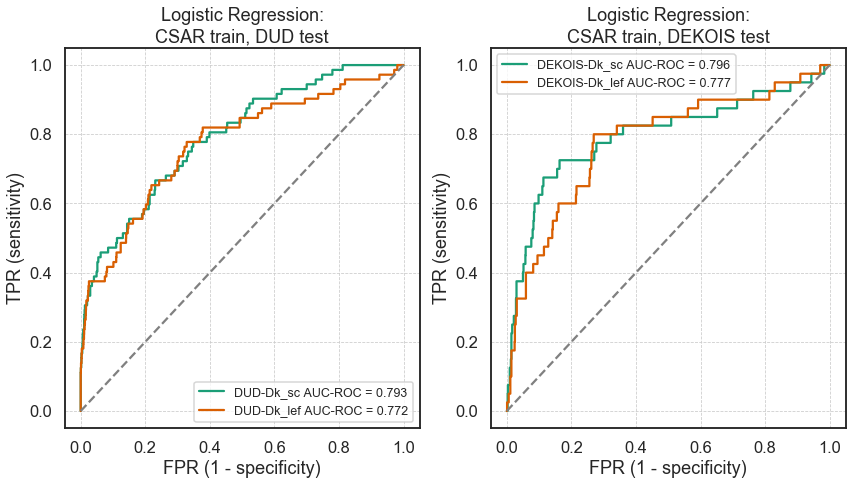

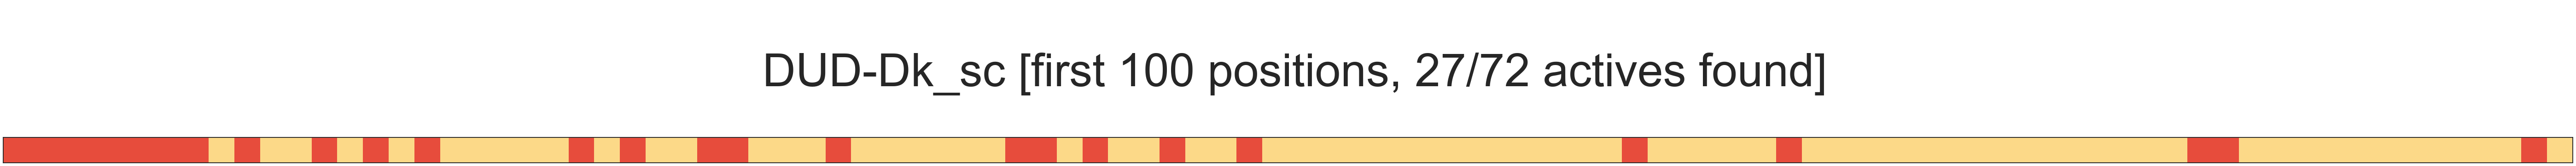

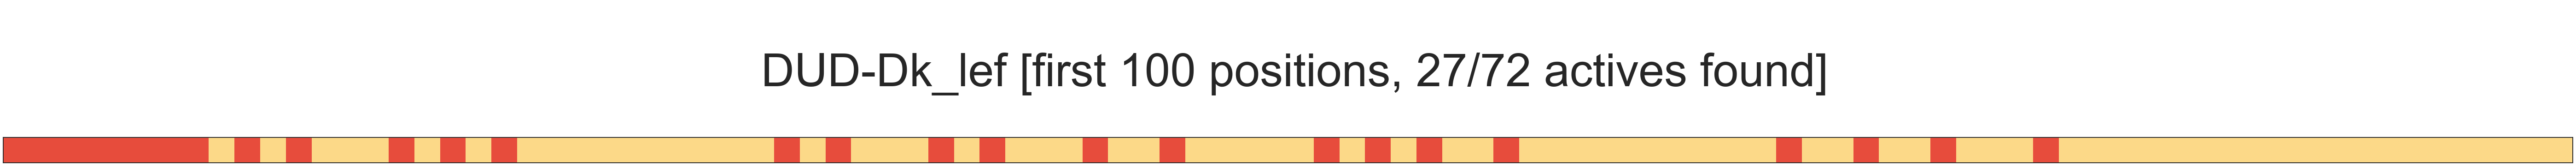

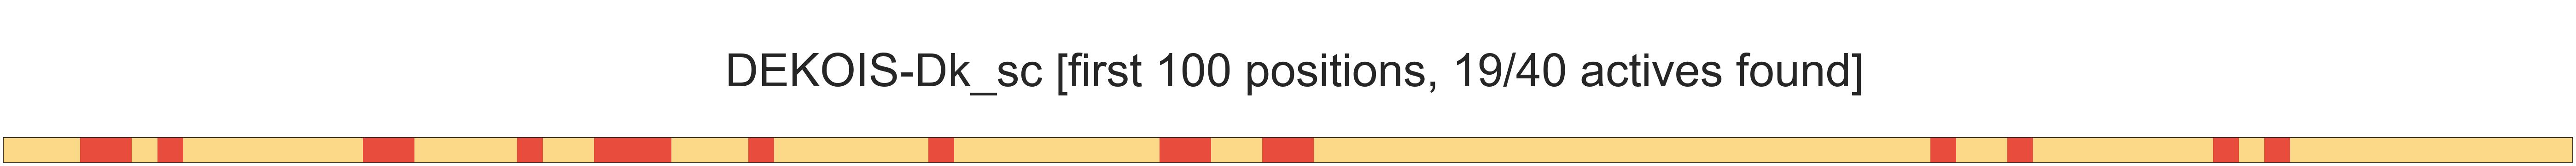

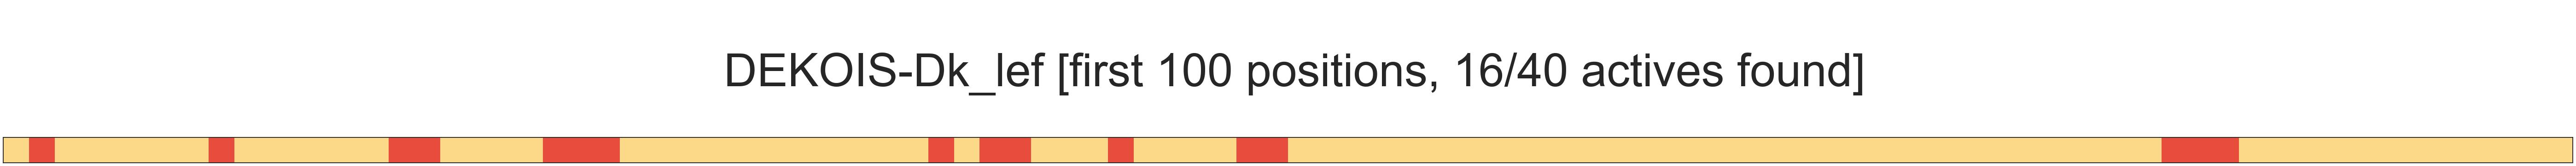

In [16]:
lg_params = {'C': [0.001, 0.01, 0.1, 1, 10], 
             'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
LG = LogisticRegression
lg_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                        estimator= LG, estimator_hyparams = lg_params)
# Parameters used
for name, model in lg_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
lg_clf_pred = eval_wrapper(trained_model = lg_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = lg_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

***
### K Neighbors Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>K Neighbors Classifier</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [17]:
from sklearn.neighbors import KNeighborsClassifier

Model for Dk_sc:
	Best parameters: {'estimator__n_neighbors': 5, 'estimator__p': 2}
	Train set accuracy: 0.879
Model for Dk_lef:
	Best parameters: {'estimator__n_neighbors': 7, 'estimator__p': 2}
	Train set accuracy: 0.94


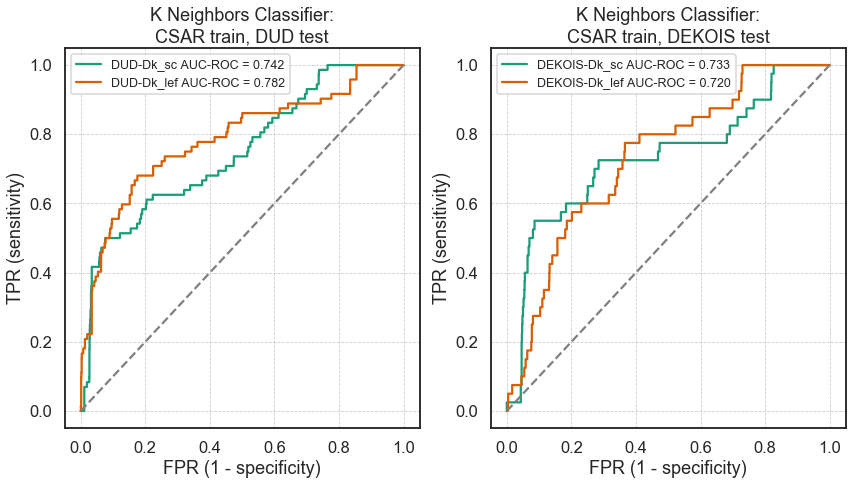

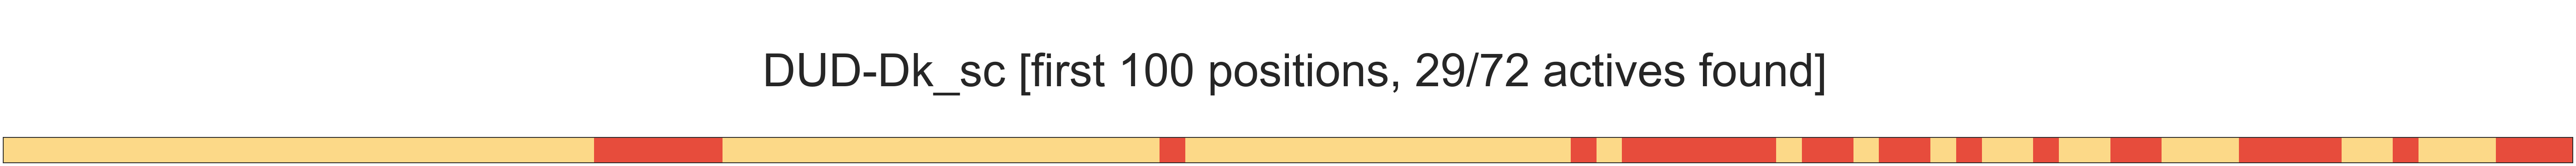

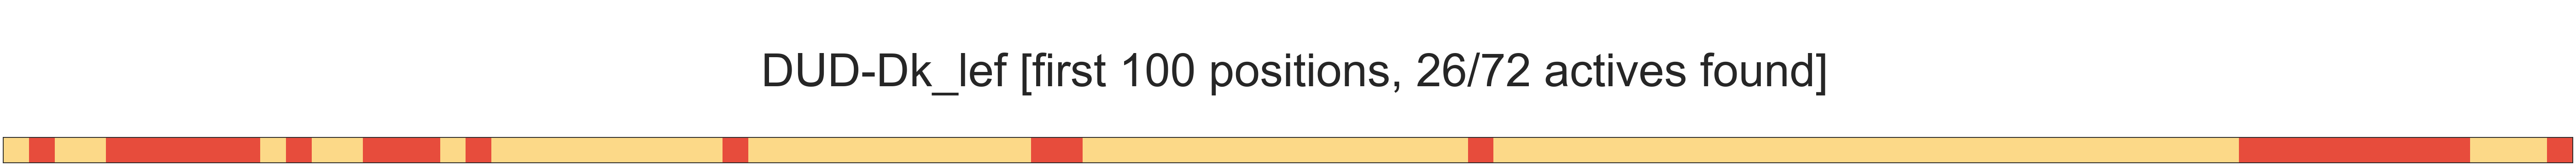

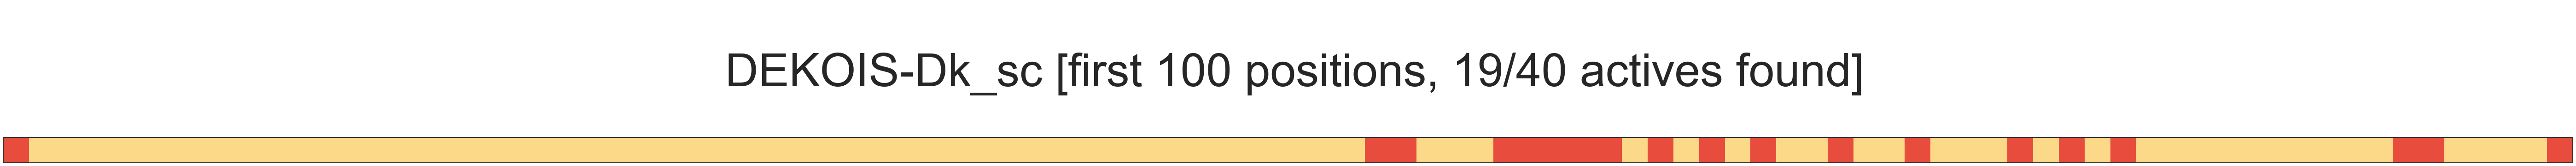

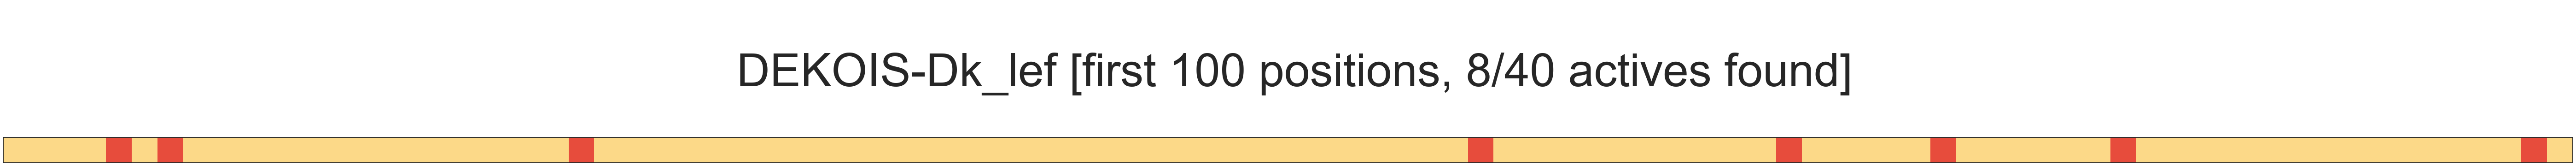

In [18]:
knc_params = {'n_neighbors': [3, 5, 7, 9, 15], 
             'p': [1, 2]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
KNC = KNeighborsClassifier
knc_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                       estimator= KNC, estimator_hyparams = knc_params,
                        # Hyperparameters
                       algorithm = 'brute', n_jobs = 4, weights = 'distance')
# Parameters used
for name, model in knc_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
knc_clf_pred = eval_wrapper(trained_model = knc_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'K Neighbors Classifier', predictions = knc_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

***
### Decision Tree Clasiffier
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Decision Tree</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [19]:
from sklearn.tree import DecisionTreeClassifier

Model for Dk_sc:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2}
	Train set accuracy: 0.821
Model for Dk_lef:
	Best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 2}
	Train set accuracy: 0.763


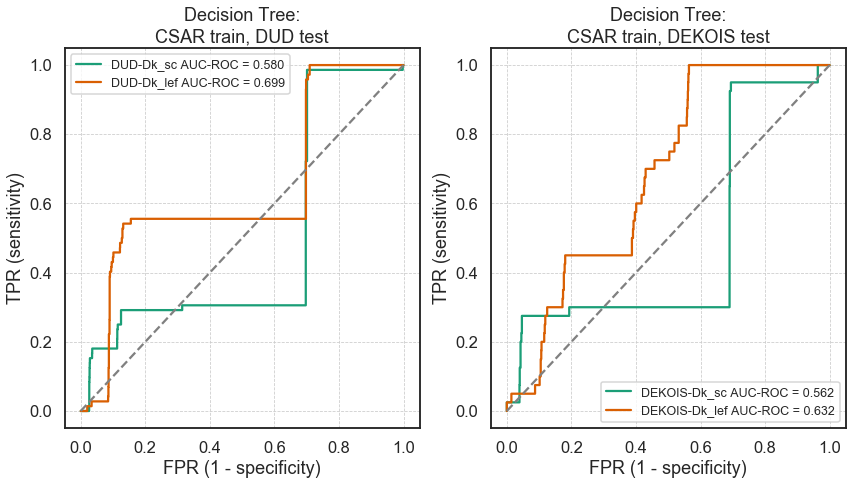

In [20]:
tree_params = {'criterion': ['gini'],
              'max_depth': [2, 3, 4, 5, 10]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
TREE = DecisionTreeClassifier
tree_clf = train_wrapper(train_key = train_key, 
                         list_of_scores = list_of_scores, scores_dic= scores_dic,
                         estimator= TREE, estimator_hyparams = tree_params,
                         standarize = False)
# Parameters used
for name, model in tree_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
tree_clf_pred = eval_wrapper(trained_model = tree_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Decision Tree', predictions = tree_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

#### Decision Tree Visualization

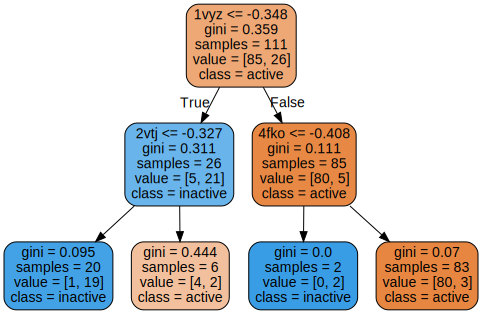

In [21]:
# Visualization
from sklearn.tree import export_graphviz
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
sns.set( context = 'paper', style = 'white', font_scale = 0.5)

# Graph tree
feature_names = scores_dic['CSAR']['Dk_lef']['X'].columns
estimator = tree_clf['Dk_lef'].best_estimator_['estimator']
graph = Source(export_graphviz(estimator, filled = True, rounded = True,
                        out_file=None, feature_names = feature_names, 
                        class_names = ['active', 'inactive']))

display(SVG(graph.pipe(format='svg')))

In [22]:
tree_LEFF = tree_clf['Dk_lef'].best_estimator_['estimator']
importances_ = tree_LEFF.feature_importances_[tree_LEFF.feature_importances_ > 0]
features_tree = feature_names[tree_LEFF.feature_importances_ > 0]

print('Feature importances TREE (Dk_Lef):')
for feature_, importance_ in zip(features_tree, importances_):
    print(F'\t{feature_}: {round(importance_, 3)}')

Feature importances TREE (Dk_Lef):
	1vyz: 0.758
	2vtj: 0.119
	4fko: 0.123


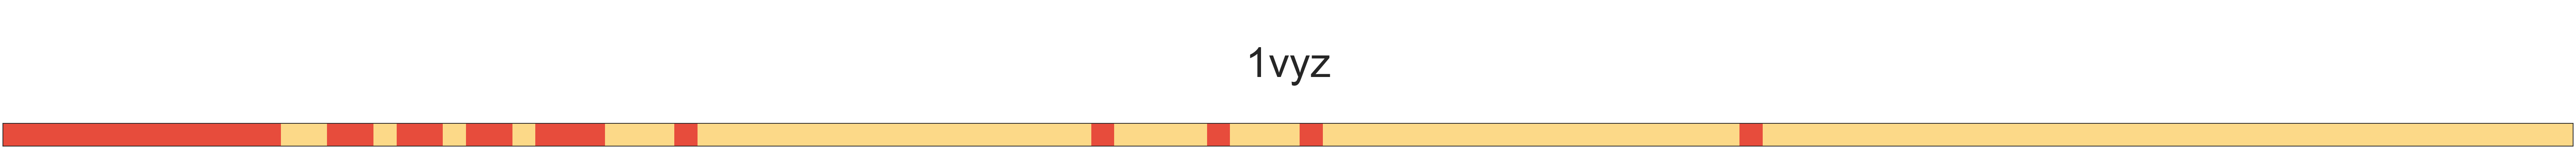

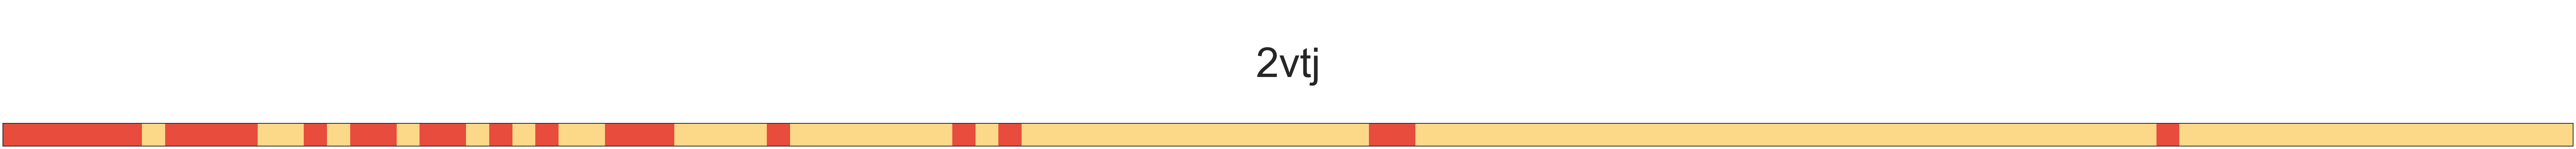

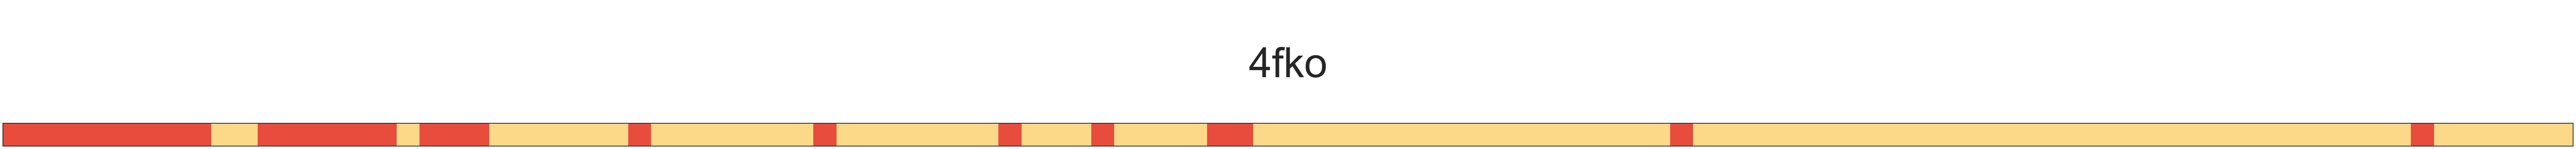

In [24]:
bc_tree_Dklef_scores = {conf: scores_dic['CSAR']['Dk_lef']['X'][conf] for conf in features_tree}

bc_tree_eval = PlotMetric(y_true = y_dkef_CSAR, y_pred_dict = bc_tree_Dklef_scores)

bc_tree_eval.plot_actives_distribution()

## Random Forest Clasiffier
<div style='background-color: #F9E5AB; min-height: 5px'></div>
<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Decision Tree</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>CSAR</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD and DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 402 conformations</i>.
    </li>
</ol>

In [25]:
from sklearn.ensemble import RandomForestClassifier

Model for Dk_sc:
	Best parameters: {'estimator__max_features': 10, 'estimator__n_estimators': 20}
	Train set accuracy: 0.854
Model for Dk_lef:
	Best parameters: {'estimator__max_features': 5, 'estimator__n_estimators': 20}
	Train set accuracy: 0.926


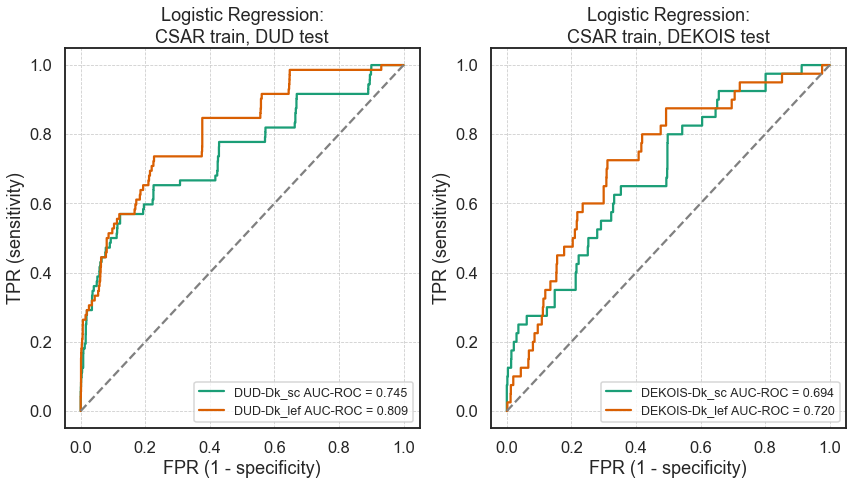

In [26]:
rf_params = {'n_estimators': [20],
             'max_features': [5, 10, 20, 30]}

list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']

# Training phase
RF = RandomForestClassifier
rf_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, scores_dic = scores_dic,
                       estimator_hyparams = rf_params, standarize = False,
                       estimator= RF, n_jobs = -1)

# Parameters used
for name, model in rf_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
rf_clf_pred = eval_wrapper(trained_model = rf_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = rf_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

### Feature selection with Random Forest

In [27]:
from sklearn.feature_selection import SelectFromModel

In [28]:
# fitted model for Dk L. Eff score
model_rf = rf_clf['Dk_lef'].best_estimator_['estimator']
# We should pass the fitted model
sel_features = SelectFromModel(model_rf, prefit= True)

In [29]:
feature_names[sel_features.get_support()]

Index(['1ckp', '1e9h', '1f5q', '1fq1', '1gz8', '1h07', '1h28', '1hcl', '1jvp',
       '1ke7', '1ke8', '1ke9', '1oiq', '1oiy', '1okv', '1ol2', '1p2a', '1pf8',
       '1pw2', '1pxi', '1pxl', '1v1k', '1vyw', '1wcc', '2bkz', '2bpm', '2bts',
       '2c4g', '2c5o', '2c68', '2fvd', '2r3l', '2r3p', '2r3q', '2uue', '2uzn',
       '2v0d', '2vth', '2vtj', '2vto', '2vv9', '2w1h', '2wpa', '3bht', '3bhv',
       '3ddp', '3ezv', '3igg', '3qqf', '3qtr', '3qtz', '3qu0', '3qxo', '3qxp',
       '3qzg', '3qzh', '3qzi', '3r1s', '3r1y', '3r7e', '3r9d', '3r9o', '3rah',
       '3rk5', '3rk9', '3rm7', '3rmf', '3s1h', '3sqq', '3sw4', '3ti1', '3tiz',
       '3uli', '3unk', '4bco', '4cfn', '4cfv', '4d1z', '4ek5', '4ek8', '4eom',
       '4erw', '4ez3', '4fkg', '4fki', '4fkj', '4fks', '4i3z', '5and', '5ank',
       '5fp5', '5iex', '5oo0', '6gub', '6gue', '6gva', '6q3b', '6q4b', '6q4h'],
      dtype='object')

In [30]:
len(feature_names[sel_features.get_support()])

99

# Filtering Features

In [31]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 15)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
conformaciones

Index(['1ke8', '2fvd', '2r3l', '2r3p', '2uzn', '3igg', '3qtz', '3qu0', '3qzg',
       '3rk9', '3sqq', '3sw4', '3unk', '4ek5', '4fkj'],
      dtype='object')

### Linear SVC with selected features
<div style='background-color: #F9E5AB; min-height: 5px'></div>

#### Random Forest Features 

Index(['2fvd', '2r3p', '2uzn', '3igg', '3qtz', '3qu0', '3sqq', '3sw4', '3unk',
       '4ek5'],
      dtype='object')


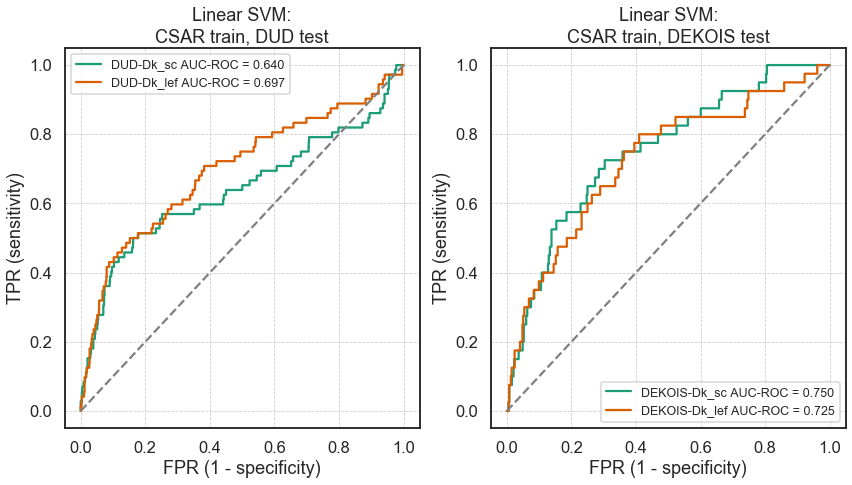

In [34]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 10)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
print(conformaciones)

svc_params = {'C': [1]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'

test_keys = ['DUD', 'DEKOIS']

svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_hyparams = svc_params, scores_dic = scores_dic,
                        selected_features = conformaciones,
                        kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


#### Decision Tree Features

Index(['1vyz', '2vtj', '4fko'], dtype='object')


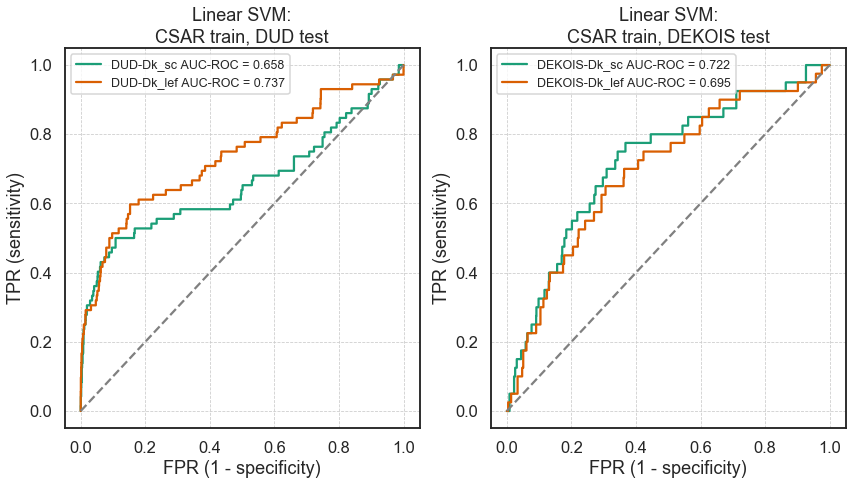

In [35]:
tree_features = features_tree
conformaciones = tree_features
print(conformaciones)

svc_params = {'C': [1]}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'

test_keys = ['DUD', 'DEKOIS']

svm = SVC
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_hyparams = svc_params, scores_dic = scores_dic,
                        selected_features = conformaciones,
                        kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization

plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


### RBF SVC with selected features
<div style='background-color: #F9E5AB; min-height: 5px'></div>

#### Random Forest Features

Index(['2fvd', '2r3p', '2uzn', '3igg', '3qtz', '3qu0', '3sqq', '3sw4', '3unk',
       '4ek5'],
      dtype='object')


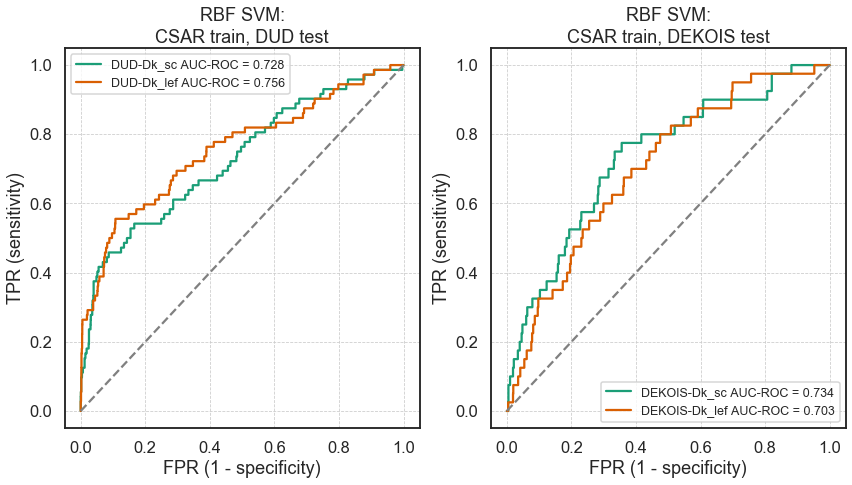

In [36]:
RF_features = SelectFromModel(model_rf, prefit= True, max_features = 10)
conformaciones = X_dkef_CSAR.columns[RF_features.get_support()]
print(conformaciones)

svc_params = {'gamma': [0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'CSAR'
test_keys = ['DUD', 'DEKOIS']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        estimator= SVC, estimator_hyparams = svc_params, scores_dic = scores_dic,
                        selected_features = conformaciones,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            selected_features = conformaciones,
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)

#### Decision Tree Features

In [ ]:
# tree_features = features_tree
# conformaciones = tree_features
# print(conformaciones)

# svc_params = {'gamma': [0.01, 0.1, 1, 10], 'C': np.geomspace(0.1, 100, 4)}
# list_of_scores = ['Dk_sc', 'Dk_lef']
# train_key = 'CSAR'
# test_keys = ['DUD', 'DEKOIS']
# # Training phase
# svm = SVC
# svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
#                         estimator= SVC, estimator_params = svc_params,
#                         selected_features = conformaciones,
#                         kernel = 'rbf', probability = True)
# # Evaluation
# svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
#                             test_keys = test_keys, list_of_scores = list_of_scores, 
#                             selected_features = conformaciones,
#                             scores_dic = scores_dic, decreasing = False)
# # Visualization
# plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
#                      train_key = train_key, plot_rankings = False, plot_nef = False)